# Step 1: Data Acquisition
In order to measure article traffic from 2015-2022, you will need to collect data from the Pageviews API. The Pageviews API (documentation, endpoint) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through the previous complete month.

You will be collecting counts of pageviews using a specified subset of Wikipedia article pages. This is a subset of the English Wikipedia that represents a large number of dinosaur related articles.

You will use the same article subset to generate several related data sets. All of the data sets are time series of monthly activity. For all of the data sets we are only interested in actual user pageview requests. The three resulting datasets should be saved as a JSON files ordered using article titles as a key for the resulting time series data. You should store the time series data as returned from the API, with the exception of removing the ‘access’ field as it is misleading for mobile and cumulative files.

## Step 1a - Configure the API request endpoints

Provide the request header and parameters with dynamic values for access and article.

### Import the required packages

Importing the packages for extraction, transformation, plotting the data

In [1]:
# These are standard python modules
import json, time, urllib.parse
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
from datetime import datetime

### Configure the endpoint details

All the endpoint details, headers and parameters are configured below. The titles of the articles are extracted from the dinosaur excel sheet provided which contains 1423 unique articles.

In [2]:
# This is just a list of dinosaur Wikipedia article titles that we can use for example requests
dinosaurs_raw = pd.read_excel('./dinosaur_genera.cleaned.SEPT.2022.xlsx')
ARTICLE_TITLES = dinosaurs_raw['name'].to_list()

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<karasth@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# REST API parameters for the json data blob from the website
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # this is the provided start date
    "end":         "2022093000"    # this is the provided end date
}

### Function for REST API call to get the article related information

Steps involved in the functione execution:
1. Pass the header, parameters and endpoint details for the GET request
2. Trigger the REST API GET request for each of the article and access type combination
3. Catch the exceptions where we couldn't extract the data from the endpoint

In [3]:
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


## Step 1b - Extract the wikipedia information for the given dinosaur article names

This step involves extracting the data for all the dinosaurs and all access types.

### Extract the wikipedia article information for various access types (Desktop, Mobile, All)

Added exception handling to highlight the articles for which we couldn't pull the information using the API endpoint

In [4]:
access_list = ['all-access', 'desktop', 'mobile-app', 'mobile-web']
df_access = list()
for i in ARTICLE_TITLES:
  # Exception handling to make sure code doesn't break
  try:
    for j in access_list:
      ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = j
      views = request_pageviews_per_article(article_title = i, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)
      df_access.append(pd.json_normalize(views['items']))
    #print("Obtained the pageview data for: ",i)
  except:
    print("Couldn't get the pageview data for: ",i)

# Obtain the overall dinosaurs data
df_dinosaurs = pd.concat(df_access)

### Save the data as excel file for future reference (Temporary)

This is a temporary step which can be neglected. 

In [5]:
# Write the raw data to excel
df_dinosaurs.to_excel('./dinosaurs_all.xlsx')
# Read the raw data from excel
df_dinosaurs = pd.read_excel('./dinosaurs_all.xlsx')
df_dinosaurs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450788 entries, 0 to 450787
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   450788 non-null  int64 
 1   project      450788 non-null  object
 2   article      450788 non-null  object
 3   granularity  450788 non-null  object
 4   timestamp    450788 non-null  int64 
 5   access       450788 non-null  object
 6   agent        450788 non-null  object
 7   views        450788 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 27.5+ MB


## Step 1c - Load the JSON data into respective files based on access type

**Monthly mobile access - ** 
The API separates mobile access types into two separate requests, you will need to sum these to make one count for all mobile pageviews. You should store the mobile access data in a file called:
dino_monthly_mobile_startYYYYMM-endYYYYMM.json

**Monthly desktop access - ** Monthly desktop page traffic is based on one single request. You should store the desktop access data in a file called:
dino_monthly_desktop_startYYYYMM-endYYYYMM.json

**Monthly cumulative - ** Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. You should store the monthly cumulative data in a file called:
dino_monthly_cumulative_startYYYYMM-endYYYYMM.json

For all of the files the startYYYYMM and endYYYYMM represent the starting and ending year and month as integer text.


### Function to write the JSON data for each access type

In [6]:
def write_json(data = df_dinosaurs, access_name = 'desktop'):
  # Aggregate the data for access type mobile
  if access_name == 'mobile':
    columns = data.columns.to_list()
    columns.remove('views')
    data = data.groupby(columns).agg({'views': np.sum}).reset_index()
  
  # Get the cumulative total
  if access_name == 'cumulative':
    columns = data.columns.to_list()
    columns.remove('views')
    data = data.groupby(columns).sum().groupby('article').cumsum().reset_index()

  data = data.sort_values(by = ['article', 'timestamp'], ascending = True)
  result = data.to_json(orient='records')[1:-1].replace('},{', '} {')
  result = '['+result+']'
  result = re.sub("}\s{", "},{", result)
  parsed = json.loads(result)
  json_object = json.dumps(parsed, indent=4)
  # Path to write JSON file
  path = f'''./json/dino_monthly_{access_name}_201507-202209.json'''
  with open(path, 'w') as f:
      f.write(json_object)

  print("JSON write complete for access type: ", access_name)

### Function to segregate the data into different files based on the access type

Pass the data and segregate into different JSON files

In [7]:
def process_json(data):
  data.reset_index(inplace=True)
  # Desktop access type
  write_json(data[data['access']=='desktop'].drop(['access', 'Unnamed: 0', 'index'], axis = 1), 'desktop')
  # Mobile access type
  write_json(data[(data['access']=='mobile-app') | (data['access'] == 'mobile-web')].drop(['access', 'Unnamed: 0', 'index'], axis = 1), 'mobile')
  # Cumulative (all-access type)
  write_json(data[data['access']=='all-access'].drop(['access', 'Unnamed: 0', 'index'], axis = 1), 'cumulative')

In [8]:
# Write the data to the respective JSON files
process_json(df_dinosaurs)

JSON write complete for access type:  desktop
JSON write complete for access type:  mobile
JSON write complete for access type:  cumulative


# Step 2 : Analysis
You will conduct a very basic visual analysis. The analysis for this homework is to graph specific subsets of the data as a timeseries. You will produce three different graphs.

## Step 2a - Maximum Average and Minimum Average 
The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

### Read the JSON files obtained from Step 1

Read the respective JSON files for mobile and desktop access types and load the data into dataframes for further transformation

In [9]:
# Read the input json files
desktop = open('./json/dino_monthly_desktop_201507-202209.json')
mobile = open('./json/dino_monthly_mobile_201507-202209.json')

# Load the JSON fiels saved in step 1
json_desktop = json.load(desktop)
json_mobile = json.load(mobile)

# Convert the JSON data into dataframes for further transformation
df_desktop = pd.json_normalize(json_desktop)
df_mobile = pd.json_normalize(json_mobile)
df_desktop.head()
df_mobile.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,443
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,412
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,283
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,794
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,311


### Function to get the data for articles that have the highest and lowest average page requests over all the months

Steps followed by the function for execution:

1. Calculate the average of article views over all the available months
2. Get the article names with maximum (highest) and minimum (lowest) average views
3. Obtain and return the wikipedia data for the above articles with category label

In [10]:
def max_min_avg(data = None, access = 'desktop'):
  grouped = data.groupby("article").mean('views')
  data['timestamp'] = data['timestamp'].astype('str')
  data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y%m%d%H')
  # Obtain the articles with maximum and minimum average page requests
  max_name = grouped.loc[grouped['views'].idxmax()].name
  min_name = grouped.loc[grouped['views'].idxmin()].name
  #print(max_name, min_name)
  # Filter the data for the above articles
  data_max = data[data['article'] == max_name][['article', 'timestamp', 'views']]
  data_min = data[data['article'] == min_name][['article', 'timestamp', 'views']]
  # Obtain the label for time series plot
  data_max['category'] = 'max_' + access
  data_max['label'] = data_max['category'] + '[' + data_max['article'] + ']'
  data_min['category'] = 'min_' + access
  data_min['label'] = data_min['category'] + '[' + data_min['article'] + ']'
  data = data_max.append(data_min)
  return data

### Obtain the data for both desktop and mobile access type

Pass both the access type labels to the above function. The data returned is then appended to a main dataframe which is used for plotting

In [11]:
# Obtain the data for time series plots
desktop = max_min_avg(df_desktop, access = 'desktop')
mobile = max_min_avg(df_mobile, access = 'mobile')
# Combine both the access type datasets
df_main = desktop.append(mobile)
df_main = df_main.set_index('timestamp')

### Plot the data for the articles with highest and lowest average page views for both desktop and mobile

A total of four time series plots will be generated (two for each access type). All four time series plots are overlapped into a single plot for comparison

In [12]:
def plot_maxmin(data):
  # Declare the figure size
  plt.figure(figsize=(16, 8), dpi=150)
  # Plot the data values
  df1 = df_main[df_main['category'] == 'max_desktop']
  df1['views'].plot(label=df1['label'].unique()[0], color='orange')
  df2 = df_main[df_main['category'] == 'min_desktop']
  df2['views'].plot(label=df2['label'].unique()[0], color='blue')
  df3 = df_main[df_main['category'] == 'max_mobile']
  df3['views'].plot(label=df3['label'].unique()[0], color='green')
  df4 = df_main[df_main['category'] == 'min_mobile']
  df4['views'].plot(label=df4['label'].unique()[0], color='black')

  # adding title to the plot
  plt.title('Maximum average and Minimum Average')
  # adding Label to the x-axis and y-axis
  plt.xlabel('Month of Visit')
  plt.ylabel('Views')
  # adding legend to the curve
  plt.legend()

  # Save the plot as a png file
  plt.savefig('./plots/max_min_average_views.png')

### Generate the Plot

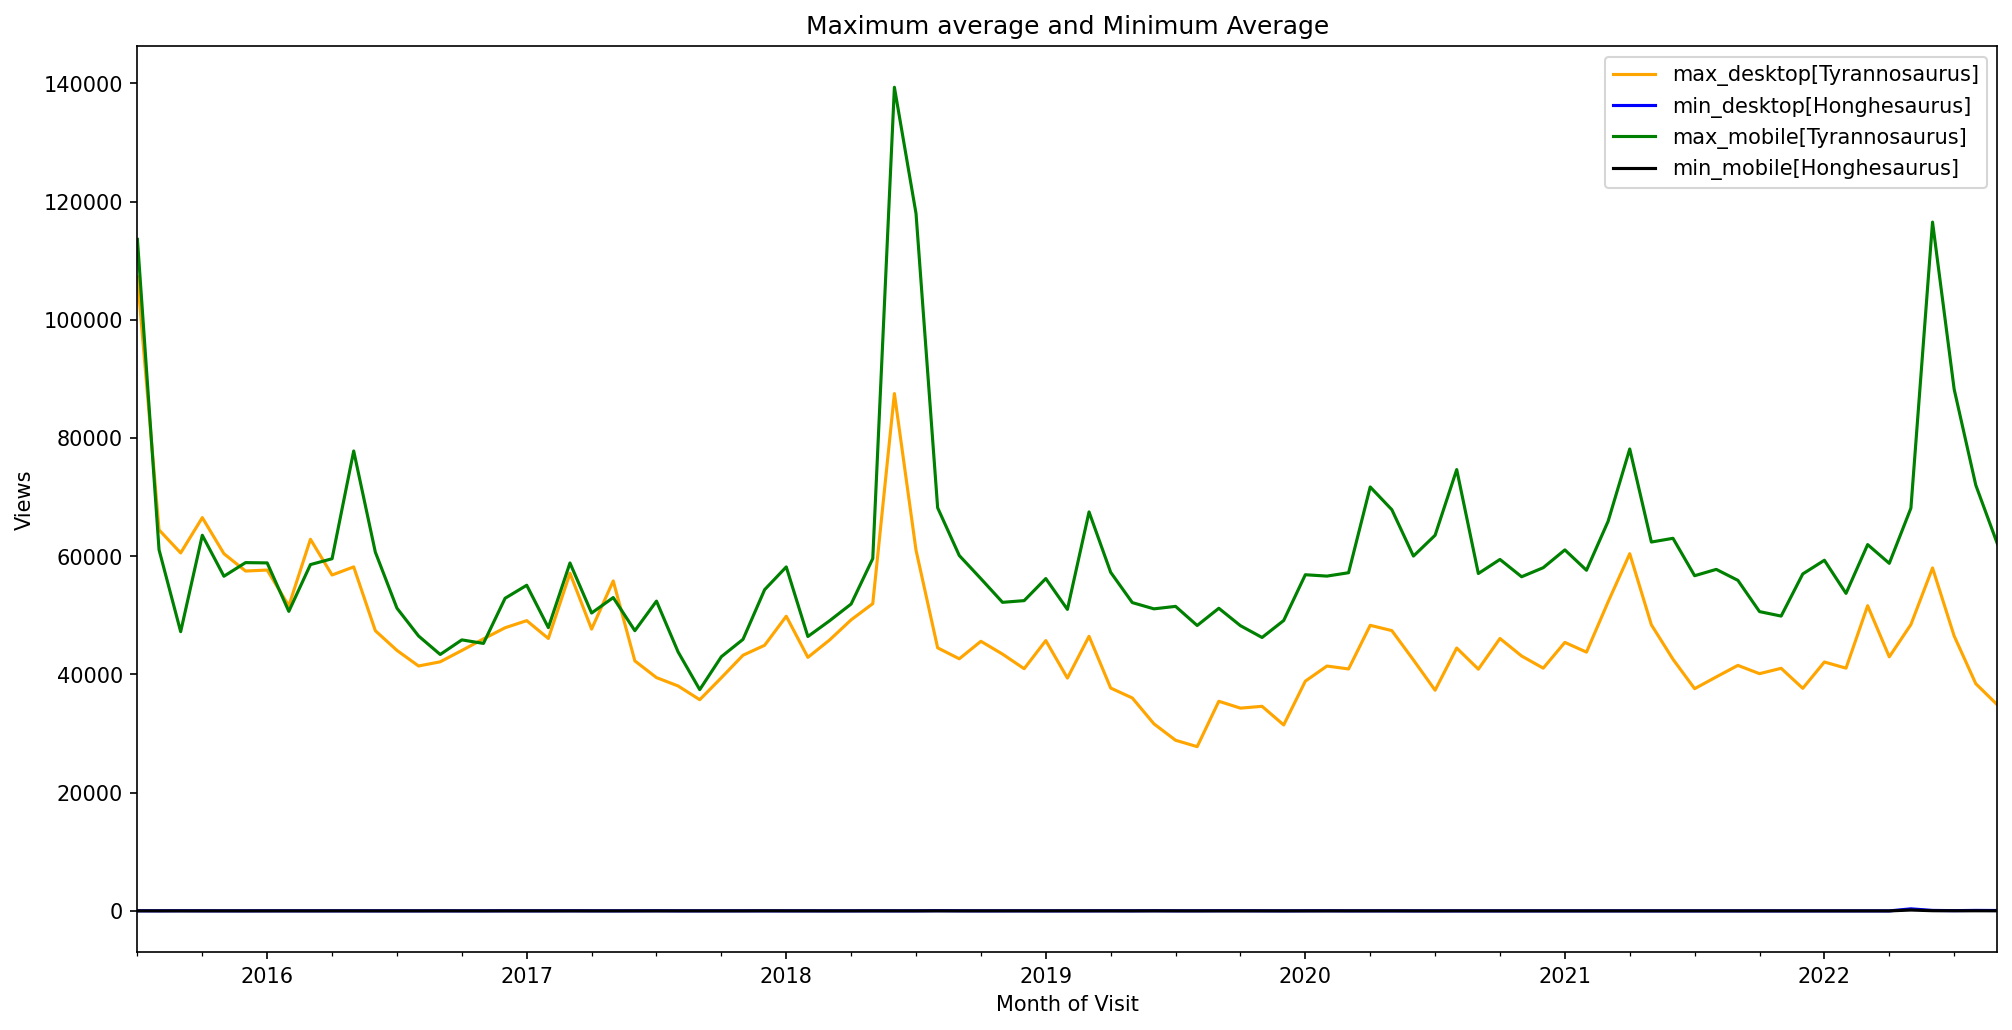

In [13]:
plot_maxmin(df_main)

## Step 2b - Top 10 Peak Page Views
The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

### Function to get the articles list that have the top 10 page views across all the months

Steps followed by the function for execution:

1. Calculate the maximum views across all the months for each article
2. Get the top 10 articles that have the largest page views and assign them a rank based on the peak views value
3. Obtain and return the wikipedia data for the above top 10 articles with category label

In [14]:
def top_ten(data = None, access = 'desktop'):
  # Obtain the top 10 articles with largest page views
  grouped = data.groupby("article").max('views').reset_index()
  grouped = grouped.sort_values(by='views', ascending=False)
  # Get the top 10 articles
  top10 = grouped.head(10)
  top10 = top10[['article']].reset_index()
  top10 = top10.drop('index', axis = 1)
  top10['rank'] = pd.Series(np.arange(1,11))
  data['access'] = access
  data = data[['article', 'timestamp', 'views', 'access']]
  # Filter the data for the above articles
  data = data.merge(top10, on='article', how = 'inner', suffixes=('_1', '_2'))
  # Obtain the label for time series plot
  data['category'] = access + '_top_' + data['rank'].astype('str') + '(' + data['article'] +')'
  return data

### Obtain the data for both desktop and mobile access type

Pass both the access type labels to the above function. The data returned is then appended to a main dataframe which is used for plotting

In [15]:
# Obtain the data for time series plots
desktop = top_ten(df_desktop, 'desktop')
mobile = top_ten(df_mobile, 'mobile')
# Combine both the access type datasets
df_main = desktop.append(mobile)
df_main = df_main.set_index('timestamp')

### Plot the data for the top 10 articles with highest page views for both desktop and mobile

A total of 20 time series plots will be generated (ten for each access type). All 20 time series plots are overlapped into a single plot for comparison

In [16]:
def plot_topten(data):
  # Declare the figure size
  plt.figure(figsize=(16, 9), dpi=150)
  
  # Plot the data values
  for i in range(1,11):
    df = data[data['rank'] == i]
    df[df['access'] == 'desktop']['views'].plot(label=df['category'].unique()[0])
    df[df['access'] == 'mobile']['views'].plot(label=df['category'].unique()[1])

  # adding title to the plot
  plt.title('Top 10 Peak Page Views')
  # adding Label to the x-axis and y-axis
  plt.xlabel('Month of Visit')
  plt.ylabel('Views')
  # adding legend to the curve
  plt.legend()

  # Save the plot as a png file
  plt.savefig('./plots/top_10_peak_page_views.png')

### Generate the Plot

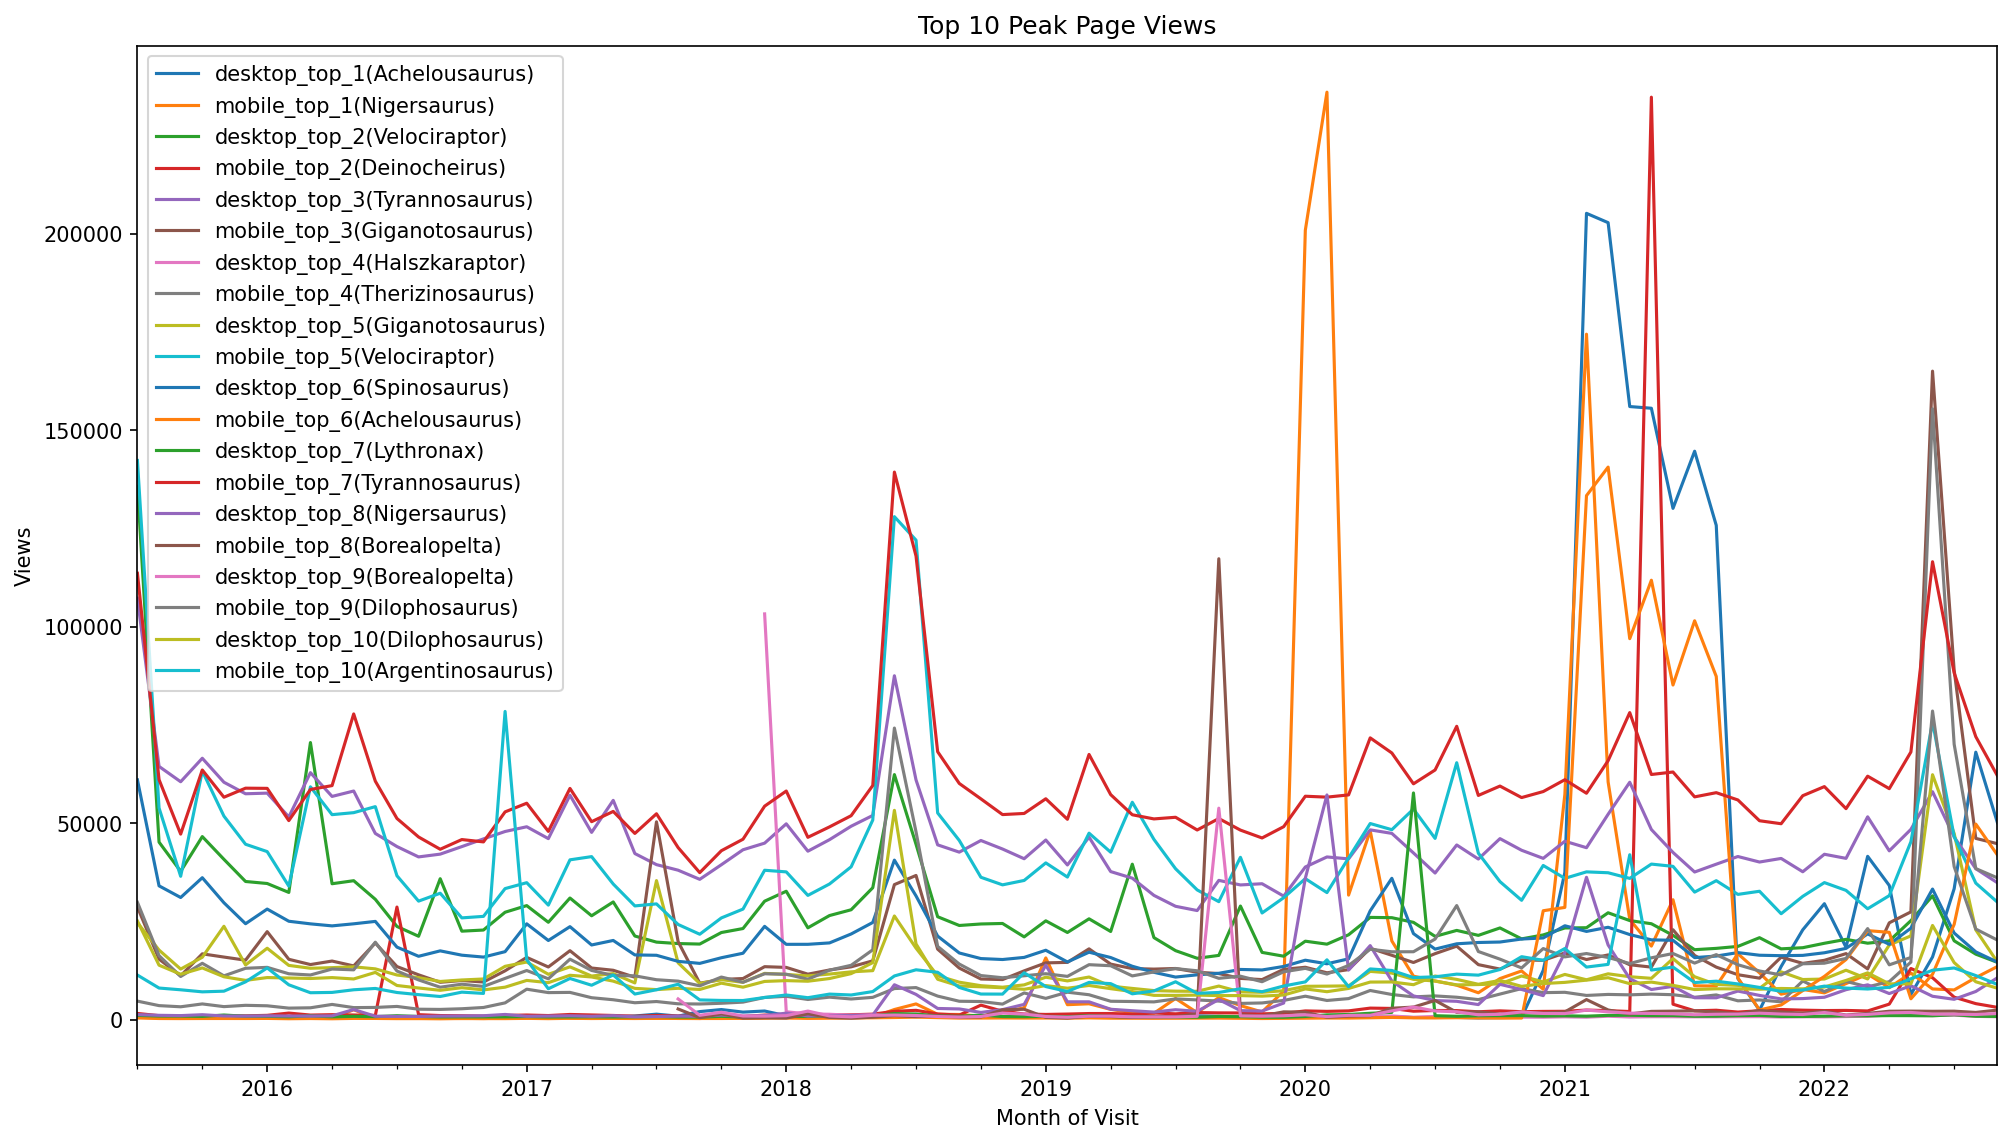

In [17]:
plot_topten(df_main)

## Step 2c - Fewest Months of Data
The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

In order to complete the analysis correctly and receive full credit, your graph will need to be the right scale to view the data; all units, axes, and values should be clearly labeled. Your graph should possess a legend and a title. You must generate a .png or .jpeg formatted image of your final graph.
You should graph the data using tools or libraries within your notebook, rather than using an external application to facilitate reproducibility.


### Function to get the articles list that have the fewest months of available data

Steps followed by the function for execution:

1. Calculate the count of months with data available for each article
2. Get the top 10 articles that have the fewest months of data and assign them a rank based on the count of months with data availability
3. Obtain and return the wikipedia data for the above top 10 articles with category label

In [18]:
def lessfreq_ten(data = None, access = 'desktop'):
  # Obtain the 10 articles with fewest months of data available
  grouped = data.groupby("article").count().reset_index().iloc[:,0:2]
  grouped = grouped.rename(columns={"project": "count"})
  grouped = grouped.sort_values(by='count', ascending=True)
  # Obtain the top 10 articles
  top10 = grouped.head(10)
  top10 = top10[['article']].reset_index()
  top10 = top10.drop('index', axis = 1)
  top10['rank'] = pd.Series(np.arange(1,11))
  data['access'] = access
  data = data[['article', 'timestamp', 'views', 'access']]
  # Filter the data for the above articles
  data = data.merge(top10, on='article', how = 'inner', suffixes=('_1', '_2'))
  # Obtain the label for time series plot
  data['category'] = access + '_least_freq_' + data['rank'].astype('str') + '(' + data['article'] +')'
  return data

### Obtain the data for both desktop and mobile access type

Pass both the access type labels to the above function. The data returned is then appended to a main dataframe which is used for plotting

In [19]:
# Obtain the data for time series plots
desktop = lessfreq_ten(df_desktop, 'desktop')
mobile = lessfreq_ten(df_mobile, 'mobile')
# Combine both the access type datasets
df_main = desktop.append(mobile)
df_main = df_main.set_index('timestamp')

### Plot the data for the articles with fewest months of available data

A total of 20 time series plots will be generated (ten for each access type). All 20 time series plots are overlapped into a single plot for comparison.

Note: The data doesn't look complete for all the articles as few articles have the least data avilability.

In [20]:
def plot_freqten(data):
  # Declare the figure size
  plt.figure(figsize=(16, 9), dpi=150)

  # Plot the data values
  for i in range(1,11):
    df = data[data['rank'] == i]
    df[df['access'] == 'desktop']['views'].plot(label=df['category'].unique()[0])
    df[df['access'] == 'mobile']['views'].plot(label=df['category'].unique()[1])

  # adding title to the plot
  plt.title('Articles with Fewest Months of Data')
  # adding Label to the x-axis and y-axis
  plt.xlabel('Month of Visit')
  plt.ylabel('Views')
  # adding legend to the curve
  plt.legend()

  # Save the plot as a png file
  plt.savefig('./plots/articles_with_fewest_months_data.png')

### Generate the Plot

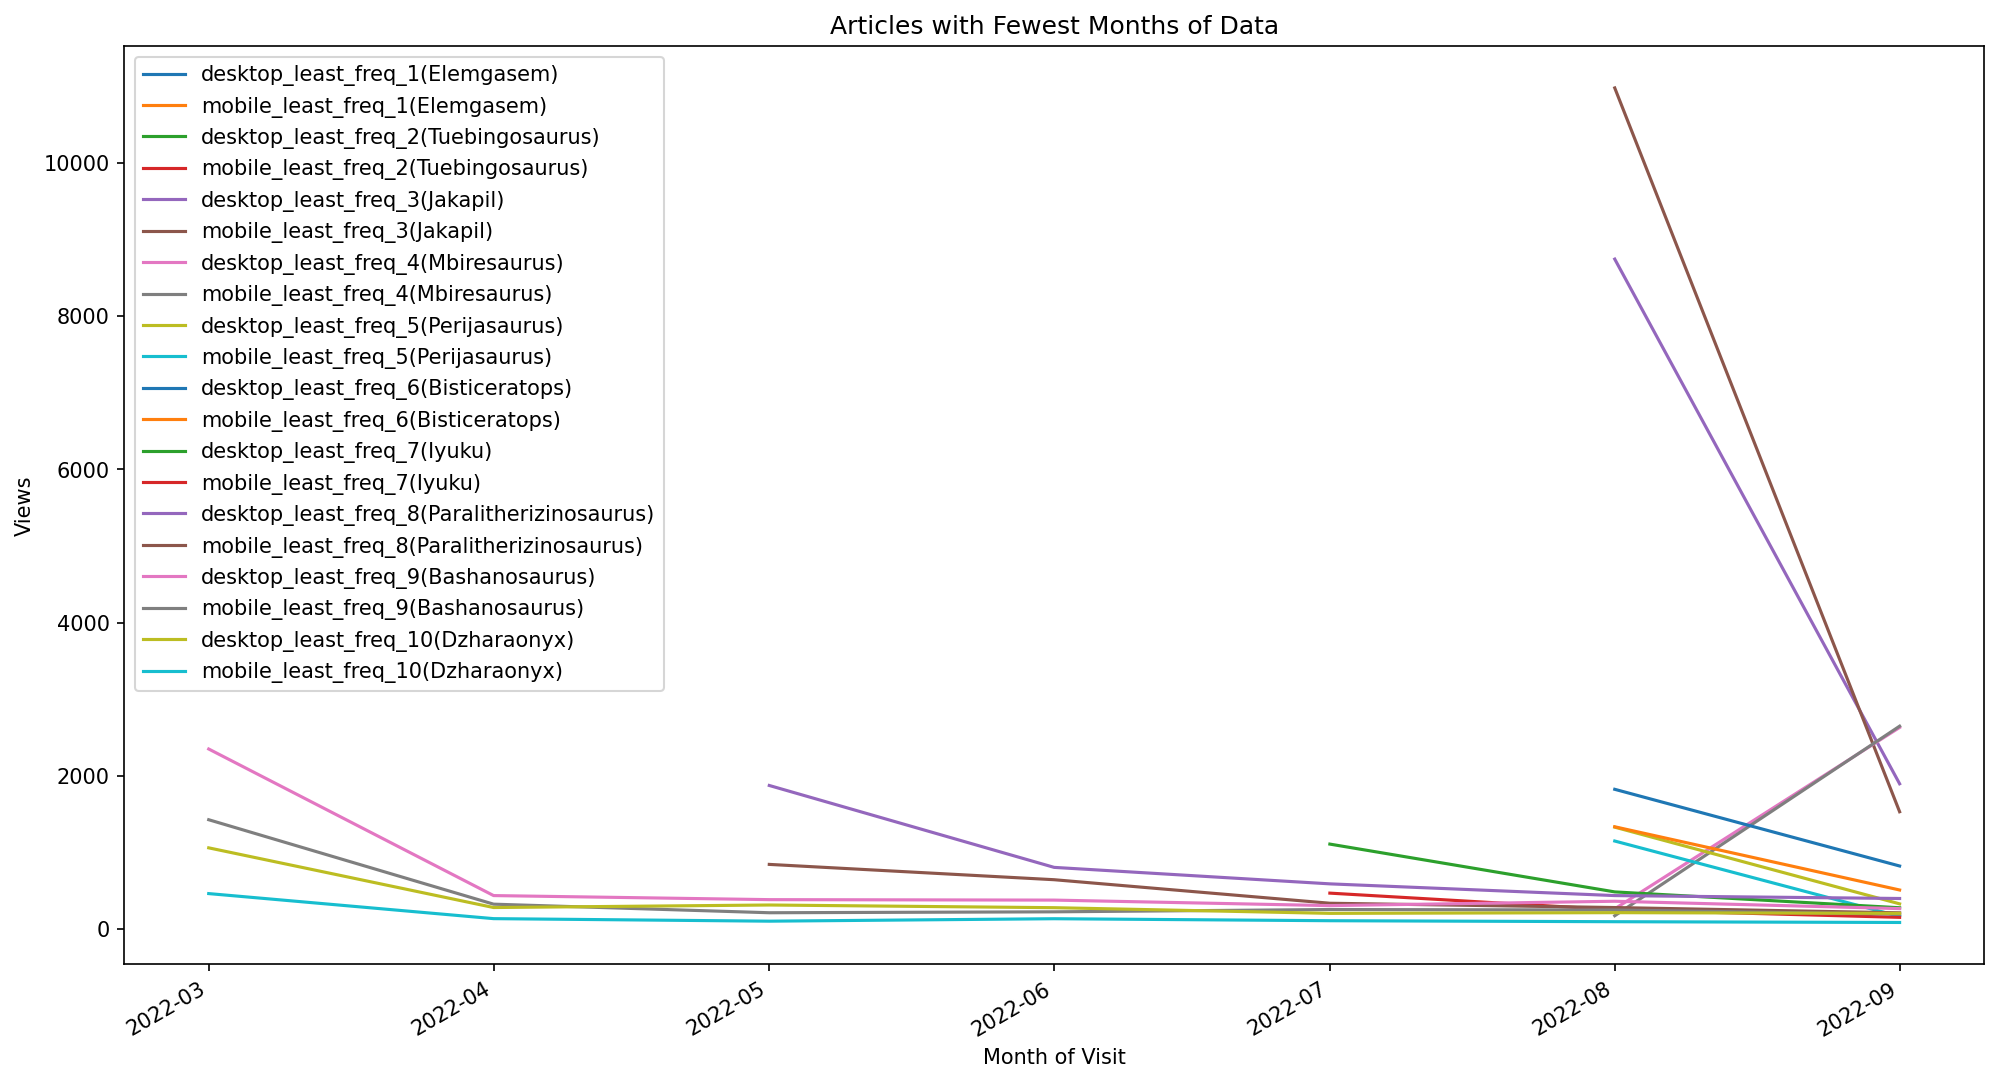

In [21]:
plot_freqten(df_main)